# Pass Rushers and Defenders in the Box vs QBs

### Goals
1. Examine how the number of pass rushers affects the QB in particular
2. May have to reduce dataset to passing situations

Note: level of detail for most of this analysis will be actual physical football play, with a number of plays per team and game in the 2018 regular season. Later on we may adjust to using quarterback as the level of detail

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# run script to get the specific quarterback, and various demographics,
# per play, from the tracking data to suplement the play data
%run "get_qbs_by_play.py"

In [3]:
# read play data created above
play_df = pd.read_csv('./data/plays_merged_with_all_files.csv')

In [4]:
# make sure we have all our columns
play_df.columns

Index(['gameId', 'gameDate', 'gameTimeEastern', 'homeTeamAbbr',
       'visitorTeamAbbr', 'week', 'playId', 'playDescription', 'quarter',
       'down', 'yardsToGo', 'possessionTeam', 'playType', 'yardlineSide',
       'yardlineNumber', 'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePI',
       'nflId', 'route', 'height', 'weight', 'birthDate', 'collegeName',
       'position', 'displayName', 'player_age'],
      dtype='object')

## Look at yards to go distributions to get a feel for overall tendencies

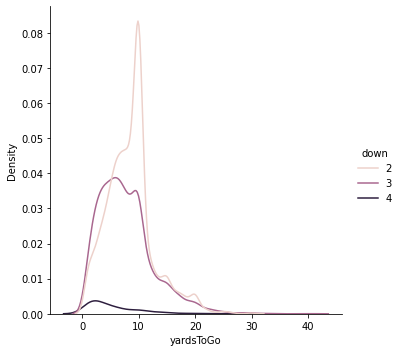

In [5]:
# across downs
sns.displot(play_df.loc[(play_df['down']>1),:], x='yardsToGo', kind='kde', hue='down')

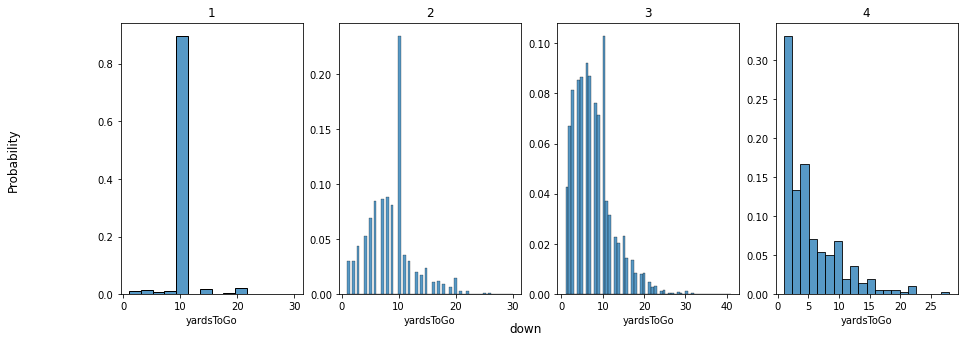

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.supxlabel('down')
fig.supylabel('Probability')

for idx,down in enumerate(range(1,5)):
    sns.histplot(play_df.loc[(play_df['down']==down),:], 
                x='yardsToGo', 
                stat='probability',
                ax=axes[idx])
    axes[idx].set_title(down)
    axes[idx].set_ylabel('')

# Defining Obvious Passing Downs to Reduce Dataset to Probable Pass Plays

### Time-score criteria:
1. Final two minutes of the first half
2. Trailing in the fourth quarter
3. Down by 21 or more points at any time
4. Down by 14 or more points after the first quarter

### Down-based criteria:
1. 2nd and 8+
2. 3rd and 5+
3. 4th and 5+

#### given:
1. Not leading in the fourth quarter
2. Not up by 21 or more points in the second half

In [7]:
# get absolute score difference for filter described above
play_df.loc[:, 'score_delta_presnap'] = play_df.apply(lambda x: x['preSnapHomeScore']-x['preSnapVisitorScore']
                                                        if x['possessionTeam'] == x['homeTeamAbbr'] 
                                                        else x['preSnapVisitorScore']-x['preSnapHomeScore']
                                                        if x['possessionTeam'] == x['visitorTeamAbbr']
                                                        else None, axis=1)

In [8]:
# function to classify as expected passing play
def is_passing(play):
    return (((play['quarter'] == 2) and (isinstance(play['gameClock'],str) and int(play['gameClock'][:2]) <= 2)) or
           ((play['quarter'] == 4) and (play['score_delta_presnap'] < 0)) or
           (play['score_delta_presnap'] < -20) or 
           ((play['quarter'] > 1) and (play['score_delta_presnap'] < -20)) or
           ((~(((play['quarter'] == 4) & (play['score_delta_presnap'] > 0)) or
           ((play['quarter'] > 2) and (play['score_delta_presnap'] > 20)))) and
           ((play['down'] == 2) and (play['yardsToGo'] > 7)) or
           ((play['down'] > 2) and (play['yardsToGo'] > 4))))

In [9]:
# apply function
play_df.loc[:, 'pass_scen'] = play_df.loc[:,:].apply(is_passing, axis=1)

In [10]:
# filter to only pass plays
pass_df = play_df.loc[play_df['pass_scen'],:]

## Examine Overall Trends for Each Factor

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='epa'>

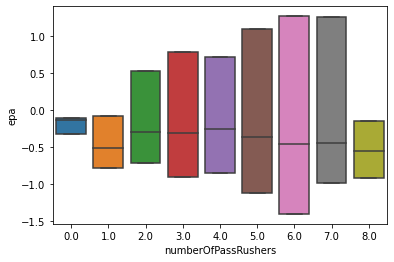

In [11]:
# look at epa dist by numberOfPassRushers
sns.boxplot(data=pass_df, 
            x='numberOfPassRushers', 
            y='epa',
            showfliers = False,
            whis=0)

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='Probability'>

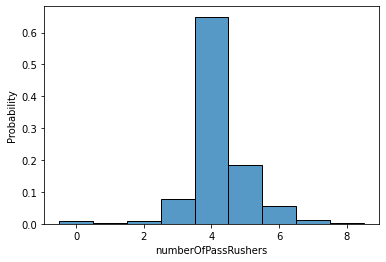

In [12]:
# hist of number of pass Rushers
sns.histplot(pass_df, 
             x='numberOfPassRushers',
             discrete=True,
             stat='probability')

<AxesSubplot:xlabel='defendersInTheBox', ylabel='epa'>

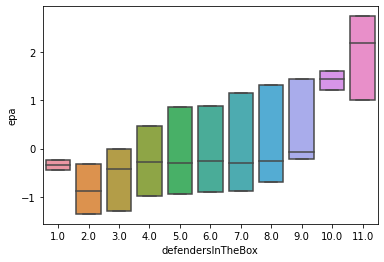

In [13]:
# briefly examine same for defenders in box-- heavily dependent on scenario
sns.boxplot(data=pass_df, 
            x='defendersInTheBox', 
            y='epa',
            showfliers = False,
            whis=0)

<AxesSubplot:xlabel='defendersInTheBox', ylabel='Probability'>

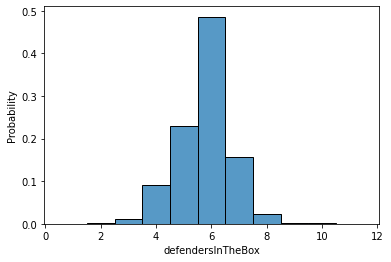

In [14]:
# again look at distribution for defenders in the box
sns.histplot(pass_df,
             x='defendersInTheBox',
             discrete=True,
             stat='probability')

### Note: Defenders in the box through the vast majority of the distribution (4-7/8 defenders) look to have very similar median EPAs and std deviations, so we will choose to only examine pass rushers in further depth, as there seems to be a stronger relationship between that and EPA

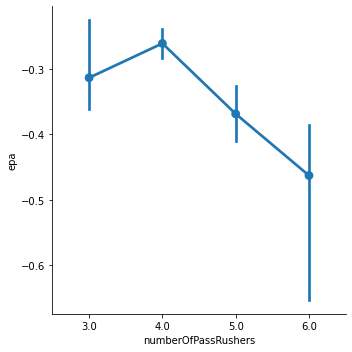

In [15]:
# lineplot with error bars across number of pass rushers for just passing plays
from numpy import median, mean
sns.catplot(data=pass_df.loc[((pass_df['numberOfPassRushers']<7) & (pass_df['numberOfPassRushers']>2)),:], 
            x='numberOfPassRushers', 
            y='epa',
            kind="point",
            estimator=median,
            ci=95)

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='Probability'>

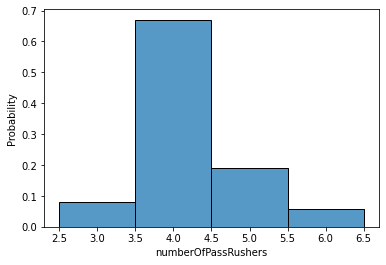

In [16]:
# look at distribution for filtered pass rush numbers --- restricted to bulk of distribution between 3 and 6 (inclusive),
# expected passing plays
sns.histplot(pass_df.loc[((pass_df['numberOfPassRushers']<7) & (pass_df['numberOfPassRushers']>2)),:], 
             x='numberOfPassRushers',
             discrete=True,
             stat='probability')

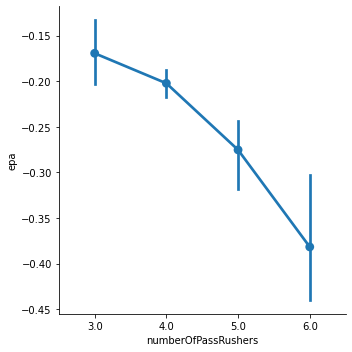

In [17]:
# same plots for all plays (not just passing) to show the difference
sns.catplot(data=play_df.loc[((play_df['numberOfPassRushers']<7) & (play_df['numberOfPassRushers']>2)),:], 
            x='numberOfPassRushers', 
            y='epa',
            kind="point",
            estimator=median,
            ci=95)

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='Probability'>

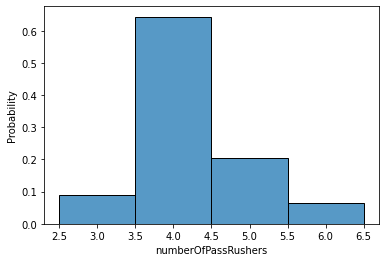

In [18]:
# again for all plays
sns.histplot(play_df.loc[((play_df['numberOfPassRushers']<7) & (play_df['numberOfPassRushers']>2)),:], 
             x='numberOfPassRushers',
             discrete=True,
             stat='probability')

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='epa std'>

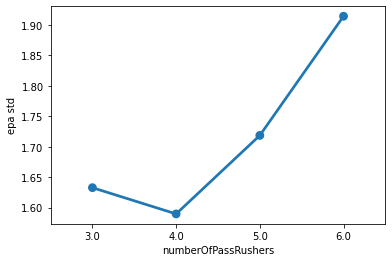

In [19]:
# back to only passing situations, look at increase in standard deviation on EPA by number of pass rushers
sns.pointplot(data=pass_df.loc[((play_df['numberOfPassRushers']<7) & (play_df['numberOfPassRushers']>2)),:] \
              .groupby('numberOfPassRushers') \
              .agg({'epa':'std'}).reset_index().rename(columns={'epa':'epa std'}), 
            x='numberOfPassRushers', 
            y='epa std')

## Look at age vs pass rushers

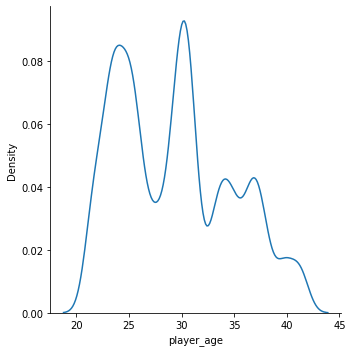

In [20]:
# look at distribution
sns.displot(pass_df, x='player_age', kind='kde')

In [21]:
# get max player age for bin to avoid using Inf
max_age = int(pass_df.loc[:,'player_age'].max())+1

In [22]:
# cut into age bins
pass_df.loc[:,'age_bin'] = pd.cut(pass_df.loc[:,'player_age'], [0,24,30,35,max_age])

c:\users\a0807345\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\a0807345\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


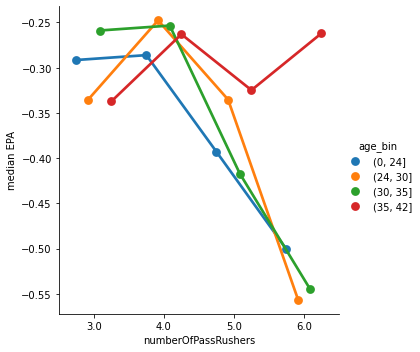

In [23]:
# plot median epa by number of pass rushers for each age group to check for difference -- again only expect pass plays
ax = sns.catplot(data=pass_df.loc[((pass_df['numberOfPassRushers']<7) & (pass_df['numberOfPassRushers']>2)),:], 
            x='numberOfPassRushers', 
            y='epa',
            kind="point",
            estimator=median,
            ci=0,
            hue='age_bin',
            dodge=0.5)
ax.set(ylabel='median EPA')

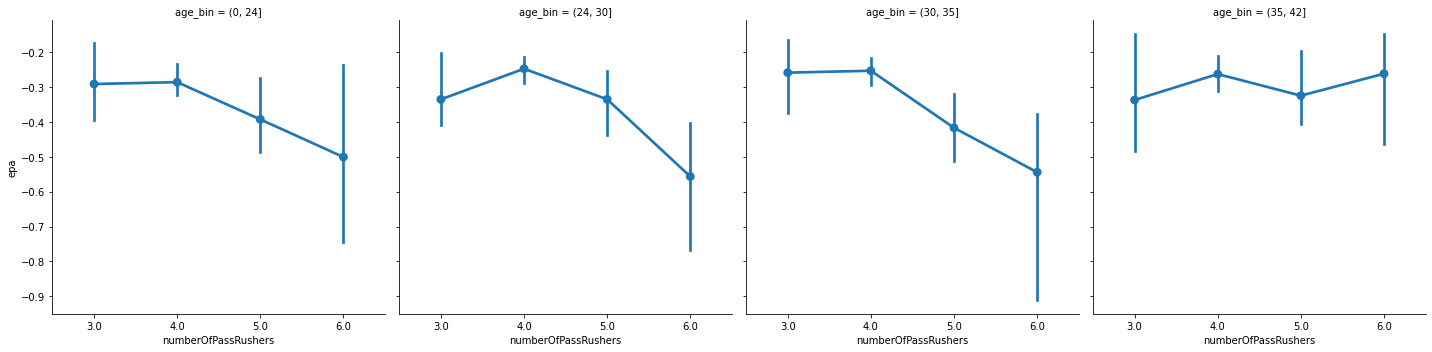

In [24]:
# split to frames for alternative plot
sns.catplot(data=pass_df.loc[((pass_df['numberOfPassRushers']<7) & (pass_df['numberOfPassRushers']>2)),:], 
            x="numberOfPassRushers", y="epa", col="age_bin", kind='point', estimator=median)

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='epa'>

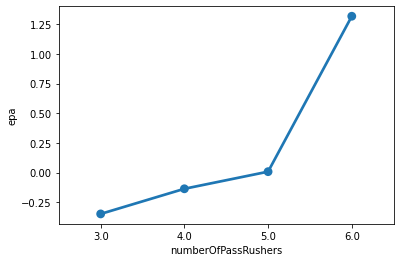

In [25]:
# look at just pat mahomes (rookie) -- to show potential variance (expect he is good against pass rush despite young age)
sns.pointplot(data=pass_df.loc[((pass_df['numberOfPassRushers']<7) & (pass_df['numberOfPassRushers']>2)
                            & (pass_df['displayName']=='Patrick Mahomes')),:], 
            x='numberOfPassRushers', 
            y='epa',
            estimator=median,
            ci=0,
            dodge=0.5)

## There seems to be a lot of noise, but the oldest age grouping seems more resistant than other groups to additional pass rushers

<AxesSubplot:xlabel='numberOfPassRushers', ylabel='displayName'>

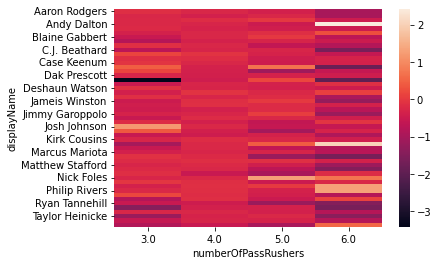

In [26]:
# heatmap to examine full distribution of median EPA by quarterback/number of pass rushers
import numpy as np
qb_map = pass_df.loc[((pass_df['numberOfPassRushers']<7) & 
             (pass_df['numberOfPassRushers']>2))].groupby(['displayName',
                                                           'numberOfPassRushers']).agg({'epa':
                                                                                        'median'}).reset_index()
qb_map = qb_map.pivot('displayName','numberOfPassRushers','epa')
qb_map = qb_map.loc[qb_map.index.isin(qb_map.reset_index().dropna()['displayName'].tolist()),:]
sns.heatmap(qb_map)

In [27]:
# get correlation between number of pass rushers and EPA by QB
qb_list = qb_map.reset_index().dropna()['displayName'].tolist()

filtered_qb = pass_df.loc[((pass_df['numberOfPassRushers']<7) & 
                           (pass_df['numberOfPassRushers']>2) & pass_df['displayName'].isin(qb_list)),:]

corr_map = filtered_qb.groupby('displayName')[['numberOfPassRushers',
                               'epa']].corr('kendall').reset_index().iloc[0::2].loc[:,['displayName',
                                                                                       'epa']].rename(columns={'epa':
                                                                                                               'kt'})
corr_map = corr_map.sort_values('kt')
corr_map = corr_map.merge(pass_df.groupby('displayName').agg({'player_age':'max'}).reset_index(), how='inner', on='displayName')
corr_map['counter'] = range(len(corr_map))

In [28]:
# filter to only qbs with 100+ plays to remove outlier QBs or QBs with few sample sizes
qb_filtered = play_df.groupby('displayName').size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
qb_filtered = qb_filtered.loc[qb_filtered['count']>=100,'displayName']

In [29]:
# apply 100 play filter to corr map
corr_map = corr_map.merge(qb_filtered, on='displayName', how='inner')

[]

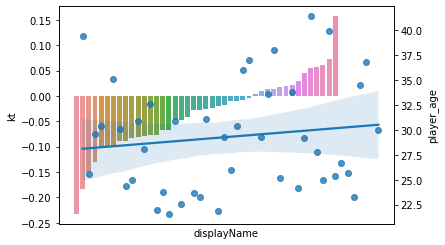

In [30]:
# rank twin plot (age to corr between pass rushers and EPA)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.barplot(data=corr_map, x='displayName', y='kt', ax=ax)
sns.regplot(data=corr_map, x='counter', y='player_age', ax=ax2)
ax.axes.xaxis.set_ticks([])

## Again, we can see somewhat of an association between age and the pass rusher correlation, but it seems to be a weaker association when applied to the full population (rather than bins). Again there is a lot of noise and variance. Also important to note than this chart uses an x value of rank, not a continuous association

In [31]:
# display corr map
corr_map

,displayName,kt,player_age,counter
0,Josh McCown,-0.232508,39.434075,1
1,Cody Kessler,-0.182449,25.618596,2
2,Cam Newton,-0.149402,29.602251,3
3,Ryan Tannehill,-0.129509,30.426361,4
4,Aaron Rodgers,-0.103138,35.078065,6
5,Russell Wilson,-0.099831,30.084122,7
6,Mitchell Trubisky,-0.099106,24.361897,8
7,C.J. Beathard,-0.089355,24.947809,9
8,Matthew Stafford,-0.088682,30.894543,10
9,Brock Osweiler,-0.083498,28.047119,11


## As said befor, there seems to be a lot of variance within the age group, let's look at Passer Rating now to examine skill

In [32]:
# define function to calculate passer rating
import re
def passer_rating(x):
    attempts = x.loc[x['passResult'].isin(['C', 'I', 'IN']),:]['passResult'].count()
    completions = x.loc[x['passResult']=='C',:]['passResult'].count()
    yds = x.loc[x['passResult']=='C',:]['playResult'].sum()
    tds = x.loc[(x['playResult'] >= x['absoluteYardlineNumber']) 
                & (x['playDescription'].str.contains('touchdown|td', flags=re.IGNORECASE, regex=True)),:]['passResult'].count()
    ints = x.loc[x['passResult']=='IN',:]['passResult'].count()
    
    a = ((completions/attempts)-0.3)*5
    b = ((yds/attempts)-3)*0.25
    c = (tds/attempts)*20
    d = 2.375-((ints/attempts)*25)
    
    fac_sum = sum([min(max(0,fac),2.375) for fac in [a]+[b]+[c]+[d]])
    
    return round((fac_sum/6)*100,1)

In [33]:
# apply passer ratings
passer_ratings = play_df.groupby('displayName').apply(passer_rating).reset_index().rename(columns={0:'passerRating'})
play_df = play_df.merge(passer_ratings, how='left', on='displayName')

In [34]:
# merge to get passer rating
corr_map = corr_map.merge(passer_ratings, how='left', on='displayName')

[]

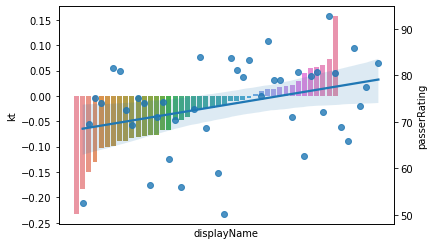

In [35]:
# same plot used with age above, now with ranks/passer ratings rather than age
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.barplot(data=corr_map, x='displayName', y='kt', ax=ax)
sns.regplot(data=corr_map, x='counter', y='passerRating', ax=ax2)
ax.axes.xaxis.set_ticks([])

In [36]:
# show overall correlation between EPA/number of pass rushers corr and passer rating by quarterback
corr_map.loc[:,['kt','passerRating']].corr() # may have to change to discrete corr (like KT or Spearman)

,kt,passerRating
kt,1.000000,0.364141
passerRating,0.364141,1.000000


[Text(0, 0.5, 'corr; number of pass rushers, EPA')]

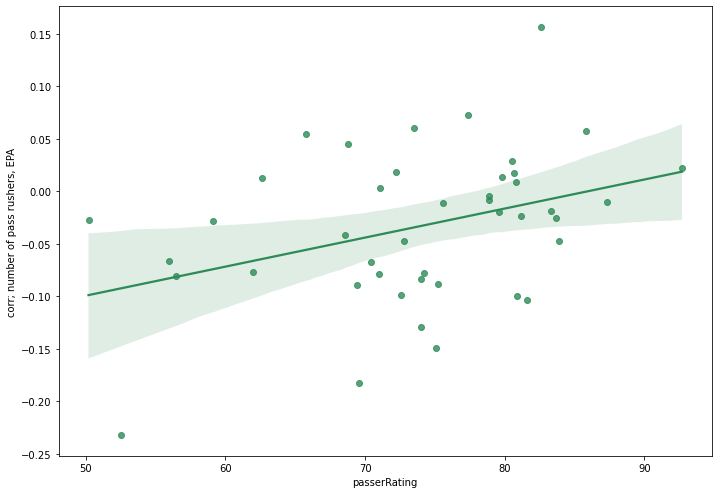

In [37]:
# plot corr by passer rating
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.regplot(data=corr_map, x='passerRating', y='kt', color='seagreen', ax=ax)
ax.set(ylabel='corr; number of pass rushers, EPA')

### This shows a distinct positive trend between number of pass rushers/EPA correlation and overall passer rating

## Revisting age to confirm weaker unbinned trend there:

[Text(0, 0.5, 'corr; number of pass rushers, EPA')]

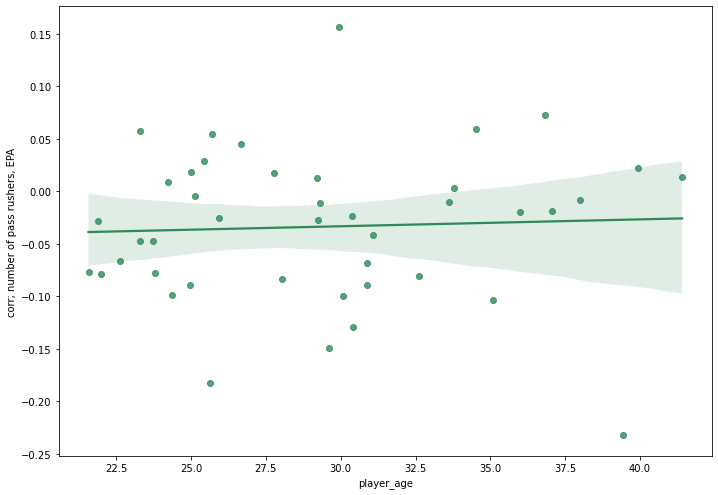

In [38]:
# revisting age, we can see that when applied to the full QB population, this is a much weaker trend,
## as there is so much variance between quarterback
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.regplot(data=corr_map, x='player_age', y='kt', color='seagreen', ax=ax)
ax.set(ylabel='corr; number of pass rushers, EPA')

In [39]:
# display corr map again
corr_map

,displayName,kt,player_age,counter,passerRating
0,Josh McCown,-0.232508,39.434075,1,52.5
1,Cody Kessler,-0.182449,25.618596,2,69.6
2,Cam Newton,-0.149402,29.602251,3,75.1
3,Ryan Tannehill,-0.129509,30.426361,4,74.0
4,Aaron Rodgers,-0.103138,35.078065,6,81.6
5,Russell Wilson,-0.099831,30.084122,7,80.9
6,Mitchell Trubisky,-0.099106,24.361897,8,72.6
7,C.J. Beathard,-0.089355,24.947809,9,69.4
8,Matthew Stafford,-0.088682,30.894543,10,75.2
9,Brock Osweiler,-0.083498,28.047119,11,74.0
